In [1]:
#IBM Data Science Applied Capstone Project Week 5

# <center> Analyzing Venues and Real Estate Prices of Delhi </center>

# 1. Introduction

### 1.1. Background

Delhi, officially the National Capital Territory of Delhi (NCT), is a city and a union territory of India containing New Delhi, the capital of India. The NCT covers an area of **1,484 square kilometers (573 sq mi)**. According to the 2011 census, Delhi's city proper population was over **16 million**, the second-highest in India. The city is divided into **272 wards**. As a resident of this city, I decided to use this for my project.

As evident from the figures, Delhi is a city with a huge population and a high population density. Being such a crowded and huge city, it must be advantageous for shop keepers, local businesses and/or investors to accurately be able to determine the locality suitable for their type of business based on several factors such as: 
* level of the population: higher the better
* price of real estate: lower prices will be preferred

At the same time, they may want to choose the district according to the density of the social places.  However, it is difficult to obtain information that will guide investors in this direction, nowadays. 
When we consider all these problems, we can create a map and information chart where the real estate index is placed on Delhi and each ward is clustered according to the venue density. Another idea is to check for correlations between the real estate prices and the population and the venue density of the wards.

### 1.2. Data Description
1. A GEOJSON file containing all the Delhi wards is used and it can be found [here](https://github.com/datameet/Municipal_Spatial_Data/blob/master/Delhi/Delhi_Wards.geojson?short_path=18d52b8). The Ward Number and Ward Name features were selected.
2. Real estate prices were manually added from [here](https://www.bankbazaar.com/home-loan/stamp-duty-and-property-registration-charges-delhi.html). There were a lot of localities for which there was no real estate price data available. It was either due to that locality being an industrial zone or it not having and residential land or there being no residential land open to the public such as government-owned properties or army cantonments. I removed those localities and continued with only those localities for which we have the real estate price data.
3. The population data was scraped from a table found [here](https://indikosh.com/city/708693/delhi).
4. Foursquare API was used to get the most common venues of given localities.

# 2. Methodology

## 2.1. Collecting and Processing Data

As discussed above, there will be three parts to the collection of data. It will be as follows:
* Part 1: Collecting the Delhi Wards Data
* Part 2: Adding Real Estate Prices
* Part 3: Adding Population Data
* Part 4: Collecting Venue data using FourSquare API

In [1]:
import json #to read the json file containing delhi spatial data
import pandas as pd 

import os #for retrieving the API keys

#libraries to geocodem, map and visualize spatial data
from geopy.geocoders import Nominatim
from geopy.geocoders import Bing
from geopy.extra.rate_limiter import RateLimiter 
import folium

import requests #for making api calls

from IPython.display import Image #to visualize the images of maps constructed
PATH = "D:/IBM Data Science/Coursera_Capstone/Delhi Analysis/"

from bs4 import BeautifulSoup #to scrape web data

### Part 1: Collecting the Delhi Wards Data

Loading the geojson file containing the spatial data for the wards of Delhi. Delhi is divided into 272 wards.

In [3]:
with open('Delhi_Wards - Copy.geojson') as json_data:
    delhi_geojson = json.load(json_data)

You can view the json file here: https://github.com/datameet/Municipal_Spatial_Data/blob/master/Delhi/Delhi_Wards.geojson?short_path=18d52b8 <br>
I have commented the below cell as the file is very big.

In [4]:
#delhi_geojson

Taking a look at the structure of one of the wards.

In [5]:
delhi_temp = delhi_geojson['features']
delhi_temp[0]

{'type': 'Feature',
 'properties': {'Ward_Name': 'CHANDNI CHOWK', 'Ward_No': '80'},
 'geometry': {'type': 'Polygon',
  'coordinates': [[[77.24385854400003, 28.661652037000067],
    [77.24402922400003, 28.66151803500003],
    [77.24412803800004, 28.660911086000056],
    [77.24467601100008, 28.660895321000055],
    [77.24755960300007, 28.658924683000066],
    [77.24827825500006, 28.658294070000068],
    [77.24848486700006, 28.656465274000027],
    [77.24914063800003, 28.654825636000055],
    [77.25082048700006, 28.652137520000053],
    [77.25112591400006, 28.651301904000036],
    [77.25135049300007, 28.651120590000062],
    [77.24561924200003, 28.650891976000025],
    [77.24386752700008, 28.65031649900004],
    [77.24035511400007, 28.650284966000072],
    [77.23906154000008, 28.649819851000075],
    [77.23654625700004, 28.65331210100004],
    [77.23648337500003, 28.65381661500004],
    [77.23686066800008, 28.65773439900005],
    [77.23675287000003, 28.65882220800006],
    [77.23520776800

#### Creating a dataframe to contain the ward number and its name.

In [6]:
delhi_neighbourhoods = pd.DataFrame(columns=['Ward Number', 'Neighbourhoods', 'Latitude', 'Longitude'])

#### Appending the Neighbourhood data into the dataframe
I had previously used the Bing API to geocode the Neighbourhoods of Delhi but it was severely inaccurate. Rather than doing that, I took the average of the boundary coordinates hoping for the average to be somewhat lying in the center. I was hoping that somebody could comment on the accuracy of this method. 

In [7]:
for data in delhi_temp:
    hood = data['properties']['Ward_Name']
    wno = data['properties']['Ward_No']
    temp = data['geometry']['coordinates'][0]
    avg = [float(sum(col))/len(col) for col in zip(*temp)]
    delhi_neighbourhoods = delhi_neighbourhoods.append({'Ward Number': wno, 
                                                        'Neighbourhoods': hood, 
                                                        'Latitude': avg[1], 
                                                        'Longitude':avg[0]}, ignore_index=True)

In [8]:
delhi_neighbourhoods.tail(10)

Ward Number      Neighbourhoods   Latitude  Longitude
53          49        ROHINI NORTH  28.738912  77.134561
54          99          MOTI NAGAR  28.669234  77.145449
55         155        LAJPAT NAGAR  28.573543  77.248105
56         163  SAFDARJANG ENCLAVE  28.558222  77.198570
57         164           HAUZ KHAS  28.556218  77.208522
58         106       TAGORE GARDEN  28.644996  77.104856
59         224        PANDAV NAGAR  28.622639  77.276422
60         205         ZAKIR NAGAR  28.571116  77.279686
61         113       MAHAVIR NAGAR  28.634869  77.077271
62         153           DARYAGANJ  28.630110  77.248757

In [9]:
delhi_neighbourhoods.to_csv(r'Neighbourhoods.csv',index=None, header=True)

### Part 2: Adding Real Estate Prices for each locality
I have used the following link to add average real estate prices per square meter in Delhi:<br>
https://www.bankbazaar.com/home-loan/stamp-duty-and-property-registration-charges-delhi.html <br>
The data entry has been manually done to the csv file created above and is then loaded below.

In [27]:
delhi_data = pd.read_csv('Neighbourhoods.csv')
delhi_data.head()

Ward Number    Neighbourhoods   Latitude  Longitude  AvgPricePerSqMtr
0           80     CHANDNI CHOWK  28.657004  77.231833             70080
1          109  JANAK PURI NORTH  28.628053  77.097987            128000
2          117   JANAK PURI WEST  28.622869  77.081633            128000
3          118  JANAK PURI SOUTH  28.615844  77.097904            128000
4          135          KAKRAULA  28.598928  77.024983             33300

### Part 3: Adding Population data
I will now be scraping the following website and adding ward-wise population data for each of Delhi's wards.
https://indikosh.com/city/708693/delhi <br>
I use beautiful soup and pandas to read and create a dataframe of the required table

In [16]:
res = requests.get("https://indikosh.com/city/708693/delhi")
soup = BeautifulSoup(res.content, 'lxml')
table = soup.find_all('table', {'class': 'table sortable'})
table = table[1]
delhi_population = pd.read_html(str(table))
delhi_population = delhi_population[0]
print(delhi_population.shape)
delhi_population.head()

(289, 2)


Wards  Population
0  Dmc (u) Ward No 125      110469
1  Dmc (u) Ward No 135      107229
2   Dmc (u) Ward No 23       94843
3  Dmc (u) Ward No 206       86392
4  Dmc (u) Ward No 147       83031

#### Stripping the Wards column to be able to merge using the Ward Number column in the delhi_select dataframe

In [17]:
delhi_population['Wards'] = delhi_population['Wards'].str.strip(r"Dmc (u) Ward No ")
delhi_population.Wards = delhi_population.Wards.astype('int64')
delhi_population.rename(columns={'Wards':'Ward Number'}, inplace=True)
delhi_population.head()

Ward Number  Population
0          125      110469
1          135      107229
2           23       94843
3          206       86392
4          147       83031

Checking dypes of **Ward Number** before merging

In [18]:
print(delhi_data.dtypes)
print(delhi_population.dtypes)

Ward Number           int64
Neighbourhoods       object
Latitude            float64
Longitude           float64
AvgPricePerSqMtr      int64
dtype: object
Ward Number    int64
Population     int64
dtype: object


In [30]:
delhi_population.to_csv(r'Population.csv',index=None, header=True)

#### Merging the two dataframes 

In [31]:
delhi_data = delhi_data.merge(delhi_population, on='Ward Number')
print(delhi_data.shape)
delhi_data.head()

(91, 6)


Ward Number    Neighbourhoods   Latitude  Longitude  AvgPricePerSqMtr  \
0           80     CHANDNI CHOWK  28.657004  77.231833             70080   
1           80     CHANDNI CHOWK  28.657004  77.231833             70080   
2          109  JANAK PURI NORTH  28.628053  77.097987            128000   
3          109  JANAK PURI NORTH  28.628053  77.097987            128000   
4          117   JANAK PURI WEST  28.622869  77.081633            128000   

   Population  
0       36296  
1        1978  
2       36168  
3       11038  
4       29997

#### Couting the missing value rows

In [32]:
delhi_data.Population.isnull().sum()

0

In [33]:
delhi_data.to_csv(r'DelhiPop.csv',index=None, header=True)

### Part 4: Collecting Venues for each locality using FourSqaure API
Now that we have all the localities for which we want to do the analysis on, all that's left is the venue data. We will now collect venues for each locality using the foursquare api. 

In [2]:
delhi_data = pd.read_csv('DelhiPop.csv')
print(delhi_data.shape)
delhi_data.head()

(63, 6)


Ward Number    Neighbourhoods   Latitude  Longitude  AvgPricePerSqMtr  \
0           80     CHANDNI CHOWK  28.657004  77.231833             70080   
1          109  JANAK PURI NORTH  28.628053  77.097987            128000   
2          117   JANAK PURI WEST  28.622869  77.081633            128000   
3          118  JANAK PURI SOUTH  28.615844  77.097904            128000   
4          135          KAKRAULA  28.598928  77.024983             33300   

   Population  
0       36296  
1       36168  
2       29997  
3       28488  
4      107229

We will first quickly visualize Delhi and the neighbourhoods on which we'll be doing our analysis. For this I'll be plotting a map of Delhi and superimposing the neighbourhoods on top of it. To do that, let's first get the geographical coordinates of Delhi.

In [35]:
address = 'Delhi, India'

geolocator = Nominatim(user_agent='Delhi')
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geographical coordinates of Delhi are {}, {}.'.format(latitude, longitude))

The geographical coordinates of Delhi are 28.6517178, 77.2219388.


#### Using folium to map Delhi and superimpose the Neighbourhoods from delhi_Data

In [36]:
map_delhi = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, hood in zip(delhi_data['Latitude'], delhi_data['Longitude'], delhi_data['Neighbourhoods']):
    label = '{}'.format(hood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_delhi)  
    
map_delhi

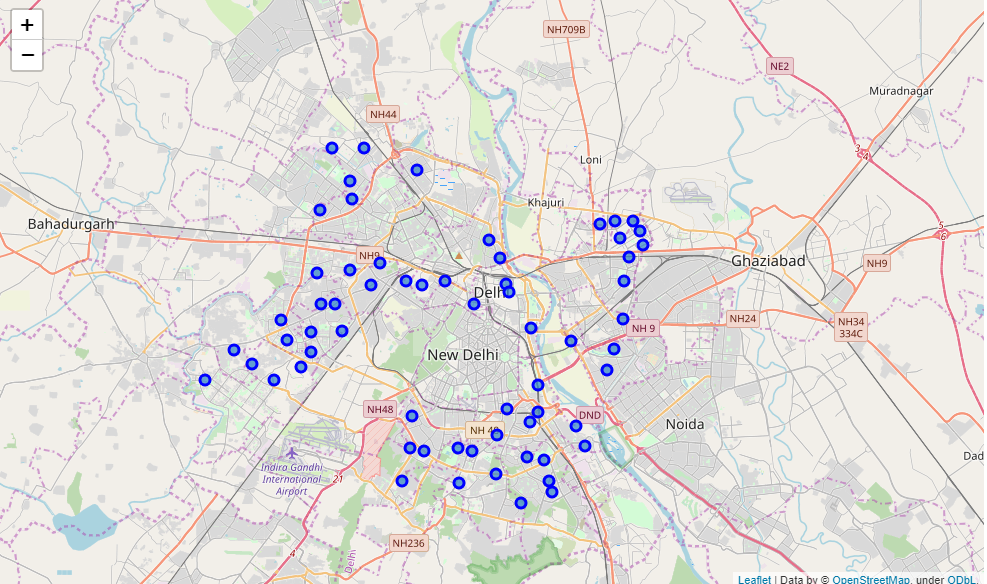

In [37]:
Image(filename = PATH + "Delhi and Neighbourhoods.png")

**Retrieving the FourSquare API Credentials**<br>
I have added the API ID and Key to the <i>environment variables</i> on Windows and I use the <i>os</i> library to import the credentials. This keeps it secure while sharing the notebook on github or with someone else.

In [38]:
CLIENT_ID = os.environ.get('FS_ID') 
CLIENT_SECRET = os.environ.get('FS_SECRET') 
VERSION = '20180604'

#print('Your credentails:')
#print('CLIENT_ID: ' + CLIENT_ID)
#print('CLIENT_SECRET:' 

#### Defining the function to obtain top venues from each Neighbourhood

In [39]:
def getNearbyVenues(names, latitudes, longitudes, radius=3000, LIMIT=100):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

#### Running the function and creating a new dataframe called <i> delhi_venues </i>.

In [40]:
delhi_venues = getNearbyVenues(names=delhi_data['Neighbourhoods'],
                               latitudes=delhi_data['Latitude'],
                               longitudes=delhi_data['Longitude'])

CHANDNI CHOWK
JANAK PURI NORTH
JANAK PURI WEST
JANAK PURI SOUTH
KAKRAULA
DILSHAD GARDEN
NEW SEEMA PURI
NAND NAGRI
SUNDER NAGARI
ASHOK NAGAR
NIZAMUDDIN
BHOGAL
KASTURBA NAGAR
MALVIYA NAGAR
ANDREWSGANJ
VASANT VIHAR
MUNIRKA
NANAK PURA
VASANTKUNJ
DAKSHINPURI EXT.
SHAPUR JAT
GREATER KAILASH-I
EAST OF KAILASH
GOVIND PURI
KALKAJI
OKHLA
PAHAR GANJ
VIVEK VIHAR
DILSHAD COLONY
PUNJABI BAGH
KIRTI NAGAR
KASHMERE GATE
MAJNU KA TILA
JAMA MASJID
UTTAM NAGAR
DABRI
MAYUR VIHAR PHASE-I
ROHINI
PASCHIM VIHAR SOUTH
ROHINI EAST
ROHINI CENTRAL
ROHINI SOUTH
I.P EXTENTION
ANAND VIHAR
MAYUR VIHAR PHASE II
MAHAVIR ENCLAVE
EAST PATEL NAGAR
WEST PATEL NAGAR
KAROL BAGH
JAHANGIRPURI-I
RAJOURI GARDEN
HARI NAGAR
MADHU VIHAR
ROHINI NORTH
MOTI NAGAR
LAJPAT NAGAR
SAFDARJANG ENCLAVE
HAUZ KHAS
TAGORE GARDEN
PANDAV NAGAR
ZAKIR NAGAR
MAHAVIR NAGAR
DARYAGANJ


Let's have a look at the delhi_venues dataframe and its shape

In [41]:
print(delhi_venues.shape)
delhi_venues.head(7)

(3620, 7)


Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0  CHANDNI CHOWK              28.657004               77.231833   
1  CHANDNI CHOWK              28.657004               77.231833   
2  CHANDNI CHOWK              28.657004               77.231833   
3  CHANDNI CHOWK              28.657004               77.231833   
4  CHANDNI CHOWK              28.657004               77.231833   
5  CHANDNI CHOWK              28.657004               77.231833   
6  CHANDNI CHOWK              28.657004               77.231833   

                                               Venue  Venue Latitude  \
0                                  Haveli Dharampura       28.653247   
1                    Karim's | करीम | کریم (Karim's)       28.649498   
2                  Jolly Creations Designer Boutique       28.662689   
3  Red Fort | Lal Qila | लाल क़िला | لال قلعہ (Re...       28.655759   
4                      Kake Di Hatti | काके दी हट्टी       28.658050   
5                                       Spice Market       28.657287   
6  Jama Masjid  |जामा मस्जिद | جامع مسجد (Jama Ma...       28.650136   

   Venue Longitude       Venue Category  
0        77.232309                Hotel  
1        77.233691    Indian Restaurant  
2        77.226300             Boutique  
3        77.241955  Monument / Landmark  
4        77.223377    Indian Restaurant  
5        77.222595    Food & Drink Shop  
6        77.233541               Mosque

We have 3,620 entries in the venue data.

In [42]:
delhi_venues.to_csv(r'DelhiVenues.csv',index=None, header=True)

## 2.2 Exploratory data analysis

Now that we have all the data we needed, it is time to dive in and make sense of the data

In [3]:
import numpy as np
from scipy.spatial.distance import cdist

#importing libraries for plotting
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means for clustering stage
from sklearn.cluster import KMeans


In [9]:
delhi_data = pd.read_csv('DelhiPop.csv')
delhi_venues = pd.read_csv('DelhiVenues.csv')

### 2.2.1. Analyzing the Venues returned for each Ward

#### Let's start with looking at the number of venues returned for each ward and sort them by count

In [10]:
summary = delhi_venues.groupby('Neighborhood').count().reset_index()
summary.drop(['Neighborhood Latitude', 'Neighborhood Longitude', 'Venue Latitude', 'Venue Longitude', 'Venue Category'], axis=1, inplace=True)
summary.rename(columns={'Neighborhood':'Neighbourhoods','Venue':'Count'}, inplace=True)
summary = summary.sort_values('Count').reset_index(drop=True)
summary.head()

Neighbourhoods  Count
0   SUNDER NAGARI      9
1      NAND NAGRI     10
2     ASHOK NAGAR     11
3  DILSHAD COLONY     11
4  JAHANGIRPURI-I     12

#### We can create a bar chart to have better visual description of it

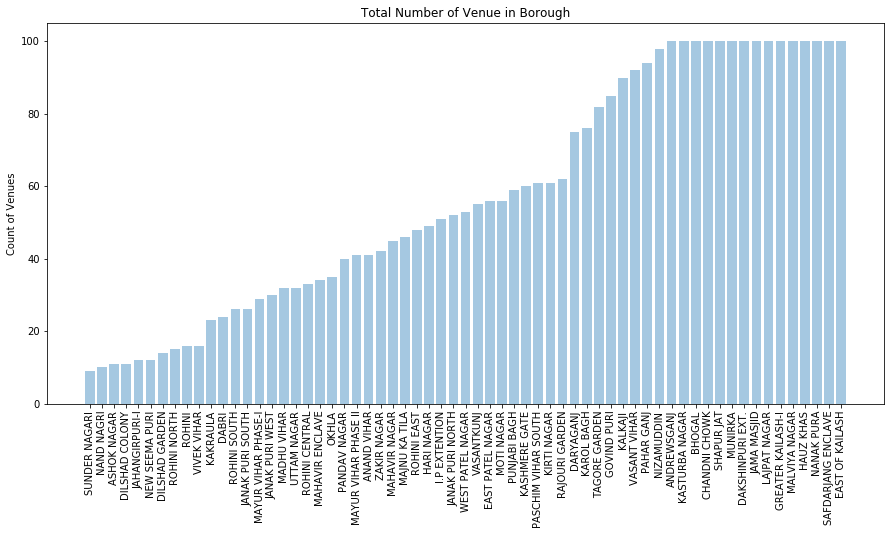

In [11]:
objects = summary.Neighbourhoods
y_pos = np.arange(len(objects))
performance = summary.Count

plt.figure(figsize=(15,7))
plt.bar(y_pos, performance, align='center', alpha=0.4)
plt.xticks(y_pos, objects)
plt.ylabel('Count of Venues')
plt.title('Total Number of Venue in Borough')
plt.xticks(rotation=90)

plt.show()

We can see that from Sunder Nagari to Vivek Vihar, which includes 10 different wards, the number of venues returned by the foursquare API are less than 20. On the other hand, there are almost 15 locations for which the number of venues returned reached the 100 limit. We can increase or decrease the number of venues returned by playing around with the radius size but we are satisfied with the result for now.

What we need to look at now, is the number of unique categories of the 3,620 venues returned.

In [12]:
print('There are {} uniques categories.'.format(len(delhi_venues['Venue Category'].unique())))

There are 170 uniques categories.


### 2.2.2. Analyzing each Ward

We will analyze each ward witht the venue information. We will start with creating a matrix, where for each Venue entry we have in the venues data we will onehot encode it against its Vanue Category, for all the neighbourhoods 

In [13]:
# one hot encoding
delhi_onehot = pd.get_dummies(delhi_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
delhi_onehot['Neighbourhoods'] = delhi_venues['Neighborhood'] 

# move neighborhood column to the first column
list_column = delhi_onehot.columns.tolist()
number_column = int(list_column.index('Neighbourhoods'))
list_column = [list_column[number_column]] + list_column[:number_column] + list_column[number_column+1:] 
delhi_onehot = delhi_onehot[list_column]

delhi_onehot.head()

Neighbourhoods  Airport Food Court  American Restaurant  Antique Shop  \
0  CHANDNI CHOWK                   0                    0             0   
1  CHANDNI CHOWK                   0                    0             0   
2  CHANDNI CHOWK                   0                    0             0   
3  CHANDNI CHOWK                   0                    0             0   
4  CHANDNI CHOWK                   0                    0             0   

   Arcade  Art Gallery  Art Museum  Arts & Crafts Store  Asian Restaurant  \
0       0            0           0                    0                 0   
1       0            0           0                    0                 0   
2       0            0           0                    0                 0   
3       0            0           0                    0                 0   
4       0            0           0                    0                 0   

   Athletics & Sports  ...  Track  Trail  Train Station  Turkish Restaurant  \
0                   0  ...      0      0              0                   0   
1                   0  ...      0      0              0                   0   
2                   0  ...      0      0              0                   0   
3                   0  ...      0      0              0                   0   
4                   0  ...      0      0              0                   0   

   Udupi Restaurant  University  Vegetarian / Vegan Restaurant  \
0                 0           0                              0   
1                 0           0                              0   
2                 0           0                              0   
3                 0           0                              0   
4                 0           0                              0   

   Vietnamese Restaurant  Yoga Studio  Zoo  
0                      0            0    0  
1                      0            0    0  
2                      0            0    0  
3                      0            0    0  
4                      0            0    0  

[5 rows x 171 columns]

What we have above is the resulting dataframe of onehot encoding each venue.

#### It is time to group all the above data by the *Neighbourhoods* and by taking the mean of the frequency of occurence  of each category.

In [14]:
delhi_grouped = delhi_onehot.groupby('Neighbourhoods').mean().reset_index()
print(delhi_grouped.shape)
delhi_grouped.head()

(63, 171)


Neighbourhoods  Airport Food Court  American Restaurant  Antique Shop  \
0    ANAND VIHAR                 0.0                  0.0           0.0   
1    ANDREWSGANJ                 0.0                  0.0           0.0   
2    ASHOK NAGAR                 0.0                  0.0           0.0   
3         BHOGAL                 0.0                  0.0           0.0   
4  CHANDNI CHOWK                 0.0                  0.0           0.0   

    Arcade  Art Gallery  Art Museum  Arts & Crafts Store  Asian Restaurant  \
0  0.02439          0.0         0.0                  0.0          0.000000   
1  0.01000          0.0         0.0                  0.0          0.020000   
2  0.00000          0.0         0.0                  0.0          0.090909   
3  0.01000          0.0         0.0                  0.0          0.010000   
4  0.00000          0.0         0.0                  0.0          0.010000   

   Athletics & Sports  ...    Track  Trail  Train Station  Turkish Restaurant  \
0             0.02439  ...  0.02439    0.0       0.024390                 0.0   
1             0.01000  ...  0.00000    0.0       0.000000                 0.0   
2             0.00000  ...  0.00000    0.0       0.090909                 0.0   
3             0.00000  ...  0.00000    0.0       0.000000                 0.0   
4             0.00000  ...  0.00000    0.0       0.000000                 0.0   

   Udupi Restaurant  University  Vegetarian / Vegan Restaurant  \
0               0.0         0.0                       0.000000   
1               0.0         0.0                       0.000000   
2               0.0         0.0                       0.090909   
3               0.0         0.0                       0.000000   
4               0.0         0.0                       0.000000   

   Vietnamese Restaurant  Yoga Studio  Zoo  
0                    0.0      0.02439  0.0  
1                    0.0      0.00000  0.0  
2                    0.0      0.00000  0.0  
3                    0.0      0.00000  0.0  
4                    0.0      0.00000  0.0  

[5 rows x 171 columns]

#### A function to sort the venues in descending order:

In [15]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

#### Creating a dataframe to display the top 10 venue category for each neighbourhood.

In [16]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighbourhoods']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
wards_venues_sorted = pd.DataFrame(columns=columns)
wards_venues_sorted['Neighbourhoods'] = delhi_grouped['Neighbourhoods']

for ind in np.arange(delhi_grouped.shape[0]):
    wards_venues_sorted.iloc[ind, 1:] = return_most_common_venues(delhi_grouped.iloc[ind, :], num_top_venues)

wards_venues_sorted.head()

Neighbourhoods 1st Most Common Venue 2nd Most Common Venue  \
0    ANAND VIHAR           Pizza Place                 Hotel   
1    ANDREWSGANJ     Indian Restaurant                Market   
2    ASHOK NAGAR    Light Rail Station                  Park   
3         BHOGAL     Indian Restaurant                  Café   
4  CHANDNI CHOWK     Indian Restaurant                 Hotel   

  3rd Most Common Venue          4th Most Common Venue 5th Most Common Venue  \
0             Multiplex                           Café  Fast Food Restaurant   
1                  Café             Italian Restaurant    Chinese Restaurant   
2         Metro Station  Vegetarian / Vegan Restaurant                 Diner   
3    Italian Restaurant           Fast Food Restaurant        Sandwich Place   
4           Snack Place           Fast Food Restaurant                  Café   

  6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
0      Department Store     Indian Restaurant         Movie Theater   
1                   Bar            Restaurant            Donut Shop   
2             Juice Bar         Train Station      Asian Restaurant   
3           Pizza Place                 Hotel           Coffee Shop   
4          Dessert Shop                   Bar                Bakery   

        9th Most Common Venue 10th Most Common Venue  
0              Shop & Service             Food Court  
1                     Stadium                 Bakery  
2  Tourist Information Center             Food Truck  
3                  Restaurant     Chinese Restaurant  
4           Food & Drink Shop            Pizza Place

### 2.2.3.  Clustering the Neighbourhoods

K-Means algorithm is one of the most common cluster method of unsupervised learning. I will use K-Means algorithm for my study in this project.

First, I will create the required dataframe to run the K-Means algorithm. I drop the categorical variable *Neighbourhoods* to create a clustering ready dataframe.

In [17]:
delhi_grouped_clustering = delhi_grouped.drop('Neighbourhoods', axis=1)
delhi_grouped_clustering.head()

Airport Food Court  American Restaurant  Antique Shop   Arcade  \
0                 0.0                  0.0           0.0  0.02439   
1                 0.0                  0.0           0.0  0.01000   
2                 0.0                  0.0           0.0  0.00000   
3                 0.0                  0.0           0.0  0.01000   
4                 0.0                  0.0           0.0  0.00000   

   Art Gallery  Art Museum  Arts & Crafts Store  Asian Restaurant  \
0          0.0         0.0                  0.0          0.000000   
1          0.0         0.0                  0.0          0.020000   
2          0.0         0.0                  0.0          0.090909   
3          0.0         0.0                  0.0          0.010000   
4          0.0         0.0                  0.0          0.010000   

   Athletics & Sports  Australian Restaurant  ...    Track  Trail  \
0             0.02439                   0.00  ...  0.02439    0.0   
1             0.01000                   0.01  ...  0.00000    0.0   
2             0.00000                   0.00  ...  0.00000    0.0   
3             0.00000                   0.00  ...  0.00000    0.0   
4             0.00000                   0.00  ...  0.00000    0.0   

   Train Station  Turkish Restaurant  Udupi Restaurant  University  \
0       0.024390                 0.0               0.0         0.0   
1       0.000000                 0.0               0.0         0.0   
2       0.090909                 0.0               0.0         0.0   
3       0.000000                 0.0               0.0         0.0   
4       0.000000                 0.0               0.0         0.0   

   Vegetarian / Vegan Restaurant  Vietnamese Restaurant  Yoga Studio  Zoo  
0                       0.000000                    0.0      0.02439  0.0  
1                       0.000000                    0.0      0.00000  0.0  
2                       0.090909                    0.0      0.00000  0.0  
3                       0.000000                    0.0      0.00000  0.0  
4                       0.000000                    0.0      0.00000  0.0  

[5 rows x 170 columns]

#### Analyzing the K-Means using the elbow method
In order to ensure that the K-Means is used in the most efficient manner we use the elbow method to correctly identify the K value for the clustering. From the graph below, I select the value for **K equal to 5** as beyond the rate at which the distortion drops slows down the most significantly.

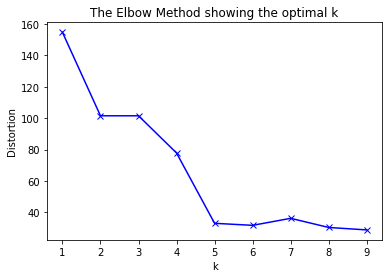

In [46]:
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(init="k-means++", n_clusters=k, n_init=12).fit(delhi_grouped_clustering)
    distortions.append(sum(np.min(cdist(delhi_grouped_clustering, kmeanModel.cluster_centers_, 'canberra'), axis=1))/delhi_grouped_clustering.shape[0])

plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

#### Running the k-means with k=5 and clustering the data

In [47]:
k = 5
kmeans = KMeans(init="k-means++", n_clusters=k, n_init=12).fit(delhi_grouped_clustering)
kmeans.labels_

array([2, 1, 3, 1, 1, 4, 1, 1, 3, 3, 1, 4, 1, 1, 4, 1, 2, 4, 1, 4, 4, 4,
       2, 1, 4, 4, 1, 4, 1, 4, 4, 4, 4, 1, 2, 2, 4, 1, 1, 3, 3, 1, 2, 1,
       2, 4, 4, 4, 0, 0, 0, 2, 0, 1, 1, 3, 4, 2, 1, 1, 3, 4, 1])

#### Creating a new dataframe consisting of both the cluster labels as well as the top 10 venues for each neighbourhood.

In [48]:
delhi_merged = delhi_data.sort_values('Neighbourhoods')
#add clustering labels
delhi_merged['Cluster Labels'] = kmeans.labels_
#merge delhi_merged with wards_venues_sorted to add latitude/longitude for each neighbourhood
delhi_merged = delhi_merged.join(wards_venues_sorted.set_index('Neighbourhoods'), on='Neighbourhoods')
delhi_merged.head()

Ward Number Neighbourhoods   Latitude  Longitude  AvgPricePerSqMtr  \
43          225    ANAND VIHAR  28.658735  77.312882            128000   
14          159    ANDREWSGANJ  28.565897  77.225581            246000   
9           246    ASHOK NAGAR  28.693261  77.296474             70380   
11          156         BHOGAL  28.579751  77.253645            774000   
0            80  CHANDNI CHOWK  28.657004  77.231833             70080   

    Population  Cluster Labels 1st Most Common Venue 2nd Most Common Venue  \
43       54339               2           Pizza Place                 Hotel   
14       46561               1     Indian Restaurant                Market   
9        50424               3    Light Rail Station                  Park   
11       46724               1     Indian Restaurant                  Café   
0        36296               1     Indian Restaurant                 Hotel   

   3rd Most Common Venue          4th Most Common Venue 5th Most Common Venue  \
43             Multiplex                           Café  Fast Food Restaurant   
14                  Café             Italian Restaurant    Chinese Restaurant   
9          Metro Station  Vegetarian / Vegan Restaurant                 Diner   
11    Italian Restaurant           Fast Food Restaurant        Sandwich Place   
0            Snack Place           Fast Food Restaurant                  Café   

   6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
43      Department Store     Indian Restaurant         Movie Theater   
14                   Bar            Restaurant            Donut Shop   
9              Juice Bar         Train Station      Asian Restaurant   
11           Pizza Place                 Hotel           Coffee Shop   
0           Dessert Shop                   Bar                Bakery   

         9th Most Common Venue 10th Most Common Venue  
43              Shop & Service             Food Court  
14                     Stadium                 Bakery  
9   Tourist Information Center             Food Truck  
11                  Restaurant     Chinese Restaurant  
0            Food & Drink Shop            Pizza Place

We can also estimate the number of 1st Most Common Venue in each cluster. Thus, we can create a bar chart which may help us to find proper label names for each cluster.

In [49]:
count_venue = delhi_merged[['Cluster Labels', '1st Most Common Venue', '2nd Most Common Venue', '3rd Most Common Venue', '4th Most Common Venue', '5th Most Common Venue', '6th Most Common Venue', '7th Most Common Venue', '8th Most Common Venue', '9th Most Common Venue', '10th Most Common Venue']]
count_venue = count_venue.groupby(['Cluster Labels', '1st Most Common Venue']).size().reset_index(name='Counts')

count_venue

Cluster Labels 1st Most Common Venue  Counts
0                0      Department Store       1
1                0  Fast Food Restaurant       2
2                0           Pizza Place       1
3                1                  Café       4
4                1           Coffee Shop       1
5                1     Indian Restaurant      18
6                2                  Café       3
7                2  Fast Food Restaurant       1
8                2     Indian Restaurant       1
9                2           Pizza Place       4
10               3                 Diner       1
11               3    Light Rail Station       1
12               3                  Park       4
13               3           Pizza Place       1
14               4  Fast Food Restaurant      10
15               4                 Hotel       1
16               4     Indian Restaurant       8
17               4           Pizza Place       1

Transposing it to plot a bar chart

In [50]:
cv_cluster = count_venue.pivot(index='Cluster Labels', columns='1st Most Common Venue', values='Counts')
cv_cluster = cv_cluster.fillna(0).astype(int).reset_index(drop=True)
cv_cluster

1st Most Common Venue  Café  Coffee Shop  Department Store  Diner  \
0                         0            0                 1      0   
1                         4            1                 0      0   
2                         3            0                 0      0   
3                         0            0                 0      1   
4                         0            0                 0      0   

1st Most Common Venue  Fast Food Restaurant  Hotel  Indian Restaurant  \
0                                         2      0                  0   
1                                         0      0                 18   
2                                         1      0                  1   
3                                         0      0                  0   
4                                        10      1                  8   

1st Most Common Venue  Light Rail Station  Park  Pizza Place  
0                                       0     0            1  
1                                       0     0            0  
2                                       0     0            4  
3                                       1     4            1  
4                                       0     0            1

#### Creating a bar chart of *Number of Venues in Each Cluster*

Text(0, 0.5, 'Frequency of Venues')

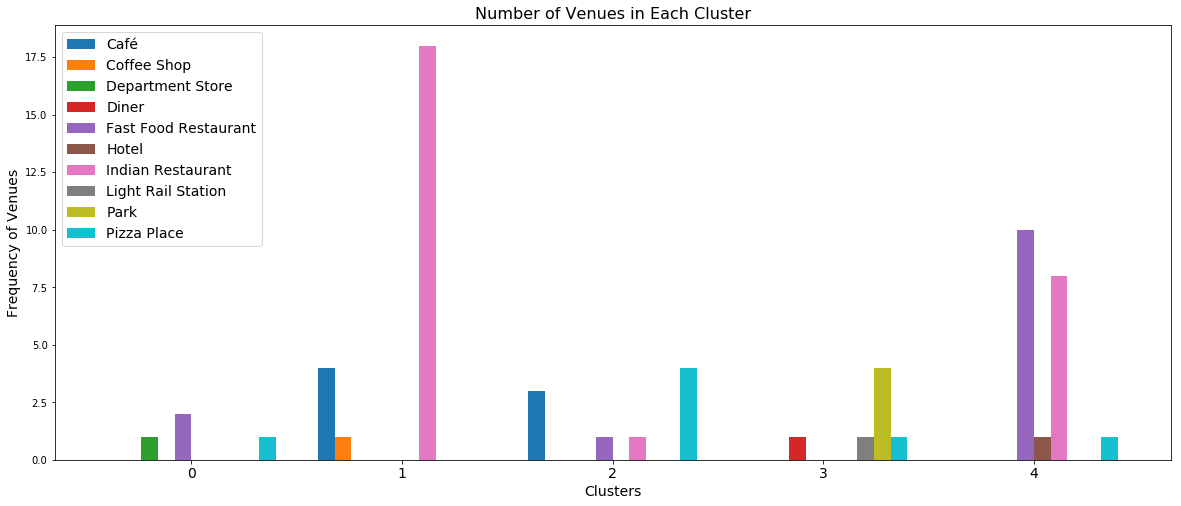

In [52]:
frame=cv_cluster.plot(kind='bar',figsize=(20,8),width = 0.8)

plt.legend(labels=cv_cluster.columns,fontsize= 14)
plt.title("Number of Venues in Each Cluster",fontsize= 16)
plt.xticks(fontsize=14)
plt.xticks(rotation=0)
plt.xlabel('Clusters', fontsize=14)
plt.ylabel('Frequency of Venues', fontsize=14)

After examining the above graph we can label each cluster as follows:
* Cluster 0: 'Departmental Stores
* Cluster 1: 'Cafe and Indian Restaurants'
* Cluster 2: 'Restaurants'
* Cluster 3: 'Fast-food'
* Cluster 4: 'Parks and Recreation'

Let's assign the new labels to the existing labels of clusters

In [54]:
Cluster_labels = {'Clusters': [0,1,2,3,4], 'Labels': ['Departmental Stores', 'Cafe and Indian Restaurants', 'Restaurants', 'Fast-food', 'Parks and Recreation']}
Cluster_labels = pd.DataFrame(data=Cluster_labels)
Cluster_labels

Clusters                       Labels
0         0          Departmental Stores
1         1  Cafe and Indian Restaurants
2         2                  Restaurants
3         3                    Fast-food
4         4         Parks and Recreation

### 2.2.4. Analyzing real estate prices

The aim is to analyze real estate sales price for per square meter in specific ranges. We will then be able to create new labels which involve pricing features, as well.

In [55]:
data_process = delhi_merged[['Neighbourhoods', 'AvgPricePerSqMtr', 'Cluster Labels']]
data_process.head()

Neighbourhoods  AvgPricePerSqMtr  Cluster Labels
43    ANAND VIHAR            128000               2
14    ANDREWSGANJ            246000               1
9     ASHOK NAGAR             70380               3
11         BHOGAL            774000               1
0   CHANDNI CHOWK             70080               1

#### Creating a histogram to visualize the frequency of real estate sales price in different ranges.

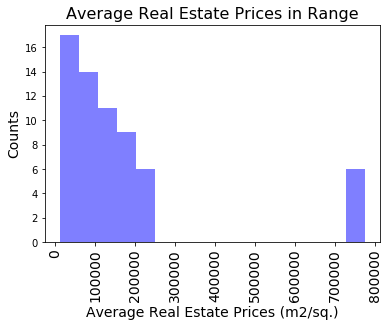

In [56]:
n, bins, patches = plt.hist(data_process['AvgPricePerSqMtr'], 16, facecolor='blue', alpha=0.5)
plt.title("Average Real Estate Prices in Range",fontsize= 16)
plt.xticks(fontsize=14)
plt.xticks(rotation=90)
plt.xlabel('Average Real Estate Prices (m2/sq.)', fontsize=14)
plt.ylabel('Counts', fontsize=14)
plt.show()

#### As it seems in above histogram, we can define the ranges as below:
* <40,000 : "Low Level"
* 40,000-80,000 : "Mid-1 Level"
* 120,000-160,000 : "Mid-2 Level"
* 240,000-280,000 : "High-1 Level"
* \>320,000 : "High-2 Level"

#### Creating *Level_labels* for the above defined levels of real estate prices

In [58]:
level = []
for i in range(0,len(data_process)):
    if (data_process['AvgPricePerSqMtr'][i] < 40000):
        level.append("Low Level HSP")
    elif (data_process['AvgPricePerSqMtr'][i] >= 40000 and data_process['AvgPricePerSqMtr'][i] < 80000):
        level.append("Mid-1 Level HSP")
    elif (data_process['AvgPricePerSqMtr'][i] >= 120000 and data_process['AvgPricePerSqMtr'][i] < 160000):
        level.append("Mid-2 Level HSP")
    elif (data_process['AvgPricePerSqMtr'][i] >= 240000 and data_process['AvgPricePerSqMtr'][i] < 280000):
        level.append("High-1 Level HSP")
    else:
        level.append("High-2 Level HSP")   

data_process['Level_labels'] = level
data_process.head()

C:\Users\rahul\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Neighbourhoods  AvgPricePerSqMtr  Cluster Labels     Level_labels
43    ANAND VIHAR            128000               2  Mid-1 Level HSP
14    ANDREWSGANJ            246000               1  Mid-2 Level HSP
9     ASHOK NAGAR             70380               3  Mid-2 Level HSP
11         BHOGAL            774000               1  Mid-2 Level HSP
0   CHANDNI CHOWK             70080               1    Low Level HSP

One of the aim was also show the number of top 3 venues information for each borough on the map. Thus, I grouped each borough by the number of top 3 venues and I combined those informations in the **Highlights** column.

In [59]:
top3 = delhi_venues.groupby(['Neighborhood','Venue Category']).size().reset_index(name='Counts')
top3 = top3.sort_values(['Neighborhood','Counts'],ascending=False).groupby('Neighborhood').head(3).reset_index(drop=True)
top3.rename(columns={'Neighborhood':'Neighbourhoods'}, inplace=True)
top3['Highlights'] = top3['Counts'].map(str) + " " + top3['Venue Category']
top3 = top3.groupby(['Neighbourhoods'])['Highlights'].apply(", ".join).reset_index()

top3.head()

Neighbourhoods                                         Highlights
0    ANAND VIHAR                     6 Pizza Place, 3 Hotel, 2 Café
1    ANDREWSGANJ             14 Indian Restaurant, 8 Market, 7 Café
2    ASHOK NAGAR   2 Light Rail Station, 2 Park, 1 Asian Restaurant
3         BHOGAL  11 Indian Restaurant, 9 Café, 6 Fast Food Rest...
4  CHANDNI CHOWK  20 Indian Restaurant, 19 Hotel, 5 Fast Food Re...

# 3. Results

## 3.1 Main Table with results

#### Let's merge those new variables with related cluster informations in our main delhi_merged table.

In [60]:
result = pd.merge(delhi_merged, 
                    top3[['Neighbourhoods', 'Highlights']],
                    on = 'Neighbourhoods',
                    how = 'left')
result= pd.merge(result, 
                    Cluster_labels[['Clusters', 'Labels']],
                    left_on = 'Cluster Labels',
                    right_on = 'Clusters',
                    how = 'left')
result = pd.merge(result, 
                    data_process[['Neighbourhoods', 'Level_labels']],
                    on = 'Neighbourhoods',
                    how = 'left')

result = result.drop(['Clusters'], axis=1)
result.head()

Ward Number Neighbourhoods   Latitude  Longitude  AvgPricePerSqMtr  \
0          225    ANAND VIHAR  28.658735  77.312882            128000   
1          159    ANDREWSGANJ  28.565897  77.225581            246000   
2          246    ASHOK NAGAR  28.693261  77.296474             70380   
3          156         BHOGAL  28.579751  77.253645            774000   
4           80  CHANDNI CHOWK  28.657004  77.231833             70080   

   Population  Cluster Labels 1st Most Common Venue 2nd Most Common Venue  \
0       54339               2           Pizza Place                 Hotel   
1       46561               1     Indian Restaurant                Market   
2       50424               3    Light Rail Station                  Park   
3       46724               1     Indian Restaurant                  Café   
4       36296               1     Indian Restaurant                 Hotel   

  3rd Most Common Venue          4th Most Common Venue 5th Most Common Venue  \
0             Multiplex                           Café  Fast Food Restaurant   
1                  Café             Italian Restaurant    Chinese Restaurant   
2         Metro Station  Vegetarian / Vegan Restaurant                 Diner   
3    Italian Restaurant           Fast Food Restaurant        Sandwich Place   
4           Snack Place           Fast Food Restaurant                  Café   

  6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
0      Department Store     Indian Restaurant         Movie Theater   
1                   Bar            Restaurant            Donut Shop   
2             Juice Bar         Train Station      Asian Restaurant   
3           Pizza Place                 Hotel           Coffee Shop   
4          Dessert Shop                   Bar                Bakery   

        9th Most Common Venue 10th Most Common Venue  \
0              Shop & Service             Food Court   
1                     Stadium                 Bakery   
2  Tourist Information Center             Food Truck   
3                  Restaurant     Chinese Restaurant   
4           Food & Drink Shop            Pizza Place   

                                          Highlights  \
0                     6 Pizza Place, 3 Hotel, 2 Café   
1             14 Indian Restaurant, 8 Market, 7 Café   
2   2 Light Rail Station, 2 Park, 1 Asian Restaurant   
3  11 Indian Restaurant, 9 Café, 6 Fast Food Rest...   
4  20 Indian Restaurant, 19 Hotel, 5 Fast Food Re...   

                        Labels     Level_labels  
0                  Restaurants  Mid-1 Level HSP  
1  Cafe and Indian Restaurants  Mid-2 Level HSP  
2                    Fast-food  Mid-2 Level HSP  
3  Cafe and Indian Restaurants  Mid-2 Level HSP  
4  Cafe and Indian Restaurants    Low Level HSP

## 3.2. Map representing Clusters
We visualize the resulting clusters and the way they are spread out. It is interesting to notice that the clusters are quite spatially seperated. 

In [61]:
k = 4
latitude = 28.6517178
longitude = 77.2219388
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(k)
ys = [i+x+(i*x)**2 for i in range(k)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster, Highlights, cluster_number, label in zip(result['Latitude'], result['Longitude'], result['Neighbourhoods'], result['Labels'], result['Highlights'], result['Cluster Labels'], result['Level_labels']):
    label = folium.Popup(str(poi) + " / " + str(cluster) + "-" + str(label) + " / " + str(Highlights), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        color= rainbow[cluster_number-1],
        popup=label,
        fill_color = rainbow[cluster_number-1],
        fill_opacity=1).add_to(map_clusters)
       
map_clusters

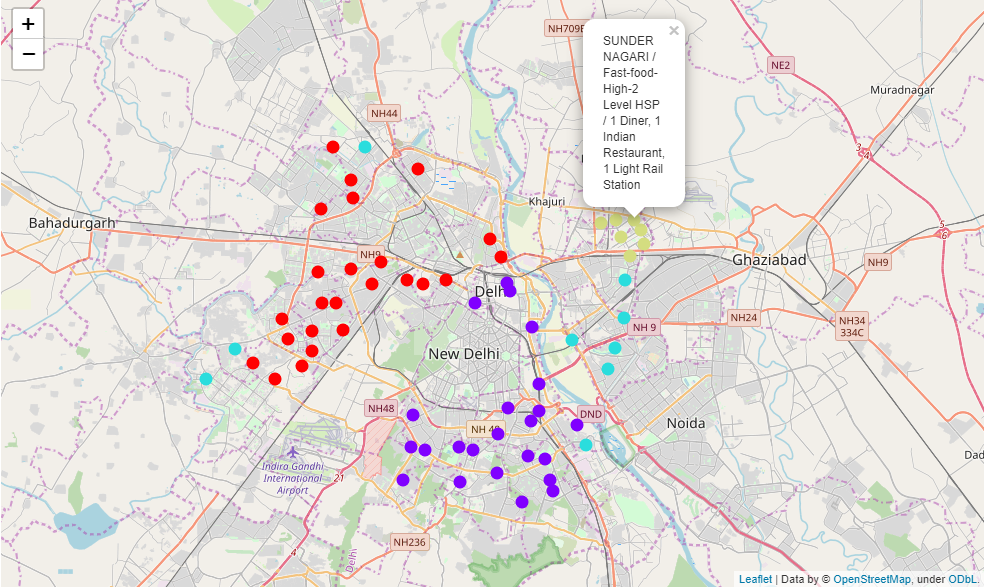

In [62]:
Image(filename = PATH + "Delhi Clusters.png")

## 3.3. Map of Real Estate Prices with Cluster information

One of the aim was also to visualize the Average Real Estate Prices per square meter for the localities under speculation using a choropleth map. For this, I used the Delhi Wards json file which was also the file used to obtain the wards of Delhi in the very beginning. The link for the same can be found under the data section in the introduction.

I had to clean up the json file to only include the neighbourhoods we were analyzing.

In [63]:
with open('Delhi_Wards - Copy.geojson') as json_data:
    delhi_geojson = json.load(json_data)

delhi_map = folium.Map(location=[latitude, longitude], zoom_start=10)

In [65]:
delhi_map.choropleth(
    geo_data=delhi_geojson,
    data=delhi_data,
    columns=['Neighbourhoods','AvgPricePerSqMtr'],
    key_on='feature.properties.Ward_Name',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='House Sales Price in Delhi',
    highlight=True
)

markers_colors = []
for lat, lon, poi, cluster, Highlights, cluster_number, label in zip(result['Latitude'], result['Longitude'], result['Neighbourhoods'], result['Labels'], result['Highlights'], result['Cluster Labels'], result['Level_labels']):
    label = folium.Popup(str(poi) + " / " + str(cluster) + "-" + str(label) + " / " + str(Highlights), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=7,
        popup=label,
        color= rainbow[cluster_number-1],
        fill=True,
        fill_color= rainbow[cluster_number-1],
        fill_opacity=1).add_to(delhi_map)
   
delhi_map

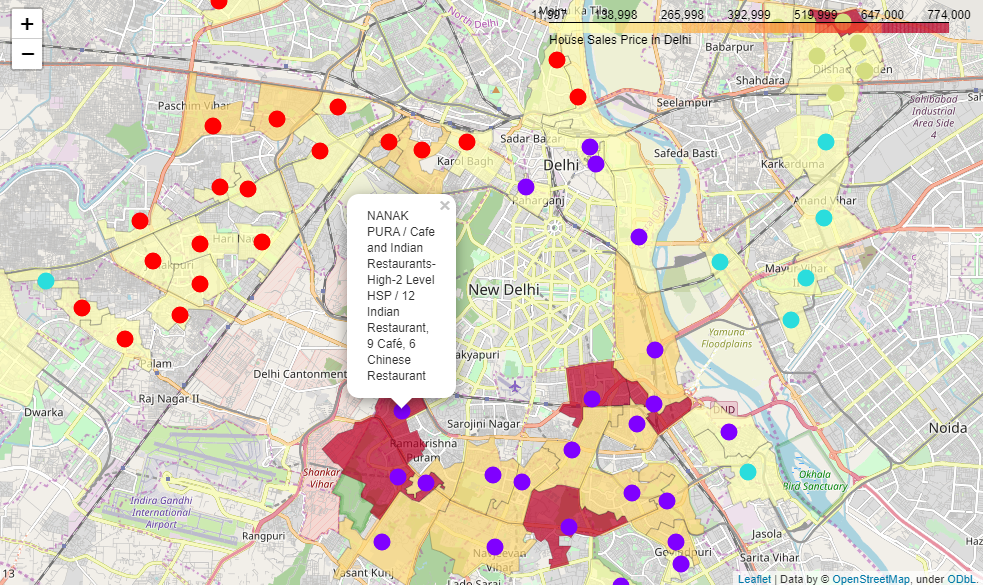

In [66]:
Image(filename = PATH + "Delhi Choropleth.png")

## 3.4. Map of Population with Cluster information
Another aim was to visualize the Population for the localities under speculation using a choropleth map.

In final section, I created choropleth map which also has the below informations for each borough:

* Neighbourhood name,
* Cluster name,
* Real Estate Price Levels,
* Top 3 number of venue

In [67]:
delhi_pop = folium.Map(location=[latitude, longitude], zoom_start=10)

delhi_pop.choropleth(
    geo_data=delhi_geojson,
    data=delhi_data,
    columns=['Neighbourhoods','Population'],
    key_on='feature.properties.Ward_Name',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Population Distribution in Delhi',
    highlight=True
)

markers_colors = []
for lat, lon, poi, cluster, Highlights, cluster_number, label in zip(result['Latitude'], result['Longitude'], result['Neighbourhoods'], result['Labels'], result['Highlights'], result['Cluster Labels'], result['Level_labels']):
    label = folium.Popup(str(poi) + " / " + str(cluster) + "-" + str(label) + " / " + str(Highlights), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=7,
        popup=label,
        color= rainbow[cluster_number-1],
        fill=True,
        fill_color= rainbow[cluster_number-1],
        fill_opacity=1).add_to(delhi_pop)
   
delhi_pop

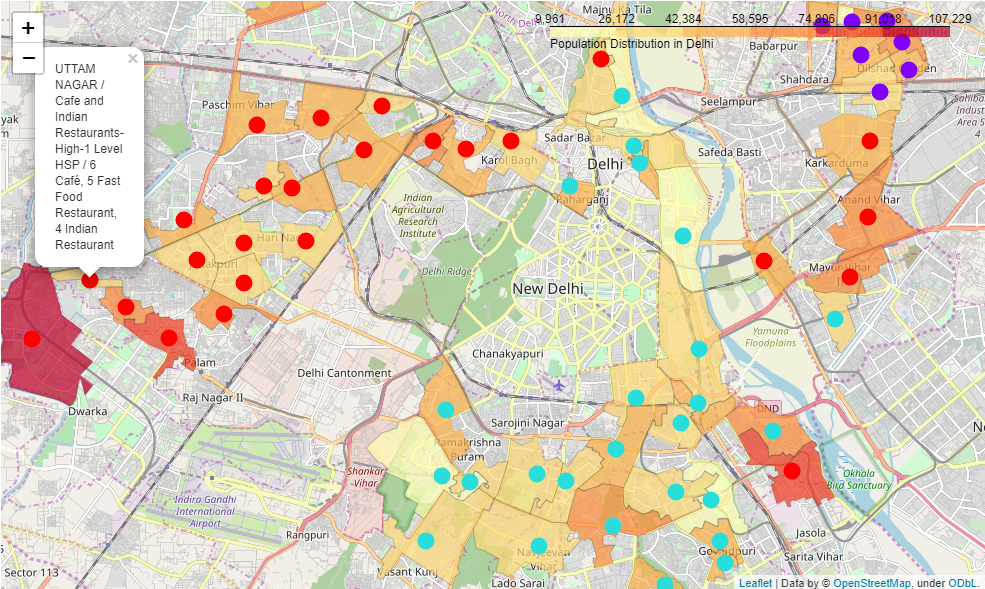

In [40]:
Image(filename = PATH + "Delhi Population.png")

# 4. Discussion
As I mentioned before, Delhi is a big city with a high population density. The total number of measurements and population densities of the different wards in total can vary. As there is such a complexity, very different approaches can be tried in clustering and classification studies. Moreover, it is obvious that not every classification method can yield the same high quality results for this metropol.

I used the Kmeans algorithm as part of this clustering study. When I tested the Elbow method, I set the optimum k value to 5. However, only 63 ward coordinates were used. For more detailed and accurate guidance, the data set can be expanded and the details of the localities or street can also be drilled.

I also performed data analysis through this information by adding the coordinates of the wards, real estate price averages and population as static data on [GitHub](https://github.com/rahul-agar/Coursera_Capstone/blob/master/DelhiHoodData.csv). In future studies, these data can also be accessed dynamically from specific platforms or packages.

I ended the study by visualizing the data and clustering information on the Delhi map. In future studies, web or telephone applications can be carried out to direct investors.

# 5. Conclusion
As a result, people are turning to big cities to start a business or work. For this reason, people can achieve better outcomes through their access to the platforms where such information is provided.

Not only for investors but also city managers can manage the city more regularly by using similar data analysis types or platform.

# 6. Future Interest and Exploration

After looking at the above choropleth map depicting the population levels and the clusters, I notice a trend for certain type of clusters and the population levels. It could give an insight into what kind of businesses flourish in ares with different kinds of population density. For this, I think we should see if there is any sort of correlations between the different venues and the population. I chose to visualize a correlation heatmap to get me started with what variables to play around with.

In [84]:
print(delhi_grouped.shape)
delhi_grouped.head()

(63, 171)


Neighbourhoods  Airport Food Court  American Restaurant  Antique Shop  \
0    ANAND VIHAR                 0.0                  0.0           0.0   
1    ANDREWSGANJ                 0.0                  0.0           0.0   
2    ASHOK NAGAR                 0.0                  0.0           0.0   
3         BHOGAL                 0.0                  0.0           0.0   
4  CHANDNI CHOWK                 0.0                  0.0           0.0   

    Arcade  Art Gallery  Art Museum  Arts & Crafts Store  Asian Restaurant  \
0  0.02439          0.0         0.0                  0.0          0.000000   
1  0.01000          0.0         0.0                  0.0          0.020000   
2  0.00000          0.0         0.0                  0.0          0.090909   
3  0.01000          0.0         0.0                  0.0          0.010000   
4  0.00000          0.0         0.0                  0.0          0.010000   

   Athletics & Sports  ...    Track  Trail  Train Station  Turkish Restaurant  \
0             0.02439  ...  0.02439    0.0       0.024390                 0.0   
1             0.01000  ...  0.00000    0.0       0.000000                 0.0   
2             0.00000  ...  0.00000    0.0       0.090909                 0.0   
3             0.00000  ...  0.00000    0.0       0.000000                 0.0   
4             0.00000  ...  0.00000    0.0       0.000000                 0.0   

   Udupi Restaurant  University  Vegetarian / Vegan Restaurant  \
0               0.0         0.0                       0.000000   
1               0.0         0.0                       0.000000   
2               0.0         0.0                       0.090909   
3               0.0         0.0                       0.000000   
4               0.0         0.0                       0.000000   

   Vietnamese Restaurant  Yoga Studio  Zoo  
0                    0.0      0.02439  0.0  
1                    0.0      0.00000  0.0  
2                    0.0      0.00000  0.0  
3                    0.0      0.00000  0.0  
4                    0.0      0.00000  0.0  

[5 rows x 171 columns]

In [100]:
df = delhi_data[['Neighbourhoods', 'AvgPricePerSqMtr', 'Population']]
print(df.shape)
df.head()

(63, 3)


Neighbourhoods  AvgPricePerSqMtr  Population
0     CHANDNI CHOWK             70080       36296
1  JANAK PURI NORTH            128000       36168
2   JANAK PURI WEST            128000       29997
3  JANAK PURI SOUTH            128000       28488
4          KAKRAULA             33300      107229

#### Mergin delhi_data conatining the real estate price and population with the delhi_grouped data containing the mean of occurences of the venues

In [101]:
df = df.merge(delhi_grouped, on='Neighbourhoods')
df.head()

Neighbourhoods  AvgPricePerSqMtr  Population  Airport Food Court  \
0     CHANDNI CHOWK             70080       36296                 0.0   
1  JANAK PURI NORTH            128000       36168                 0.0   
2   JANAK PURI WEST            128000       29997                 0.0   
3  JANAK PURI SOUTH            128000       28488                 0.0   
4          KAKRAULA             33300      107229                 0.0   

   American Restaurant  Antique Shop    Arcade  Art Gallery  Art Museum  \
0                  0.0           0.0  0.000000          0.0         0.0   
1                  0.0           0.0  0.019231          0.0         0.0   
2                  0.0           0.0  0.033333          0.0         0.0   
3                  0.0           0.0  0.038462          0.0         0.0   
4                  0.0           0.0  0.000000          0.0         0.0   

   Arts & Crafts Store  ...  Track  Trail  Train Station  Turkish Restaurant  \
0                  0.0  ...    0.0    0.0       0.000000                 0.0   
1                  0.0  ...    0.0    0.0       0.019231                 0.0   
2                  0.0  ...    0.0    0.0       0.033333                 0.0   
3                  0.0  ...    0.0    0.0       0.000000                 0.0   
4                  0.0  ...    0.0    0.0       0.000000                 0.0   

   Udupi Restaurant  University  Vegetarian / Vegan Restaurant  \
0               0.0         0.0                            0.0   
1               0.0         0.0                            0.0   
2               0.0         0.0                            0.0   
3               0.0         0.0                            0.0   
4               0.0         0.0                            0.0   

   Vietnamese Restaurant  Yoga Studio  Zoo  
0                    0.0          0.0  0.0  
1                    0.0          0.0  0.0  
2                    0.0          0.0  0.0  
3                    0.0          0.0  0.0  
4                    0.0          0.0  0.0  

[5 rows x 173 columns]

#### Setting the Neighbourhoods column as the index to continue work on the quantitative data

In [102]:
df.set_index('Neighbourhoods', inplace=True)
df.head()

AvgPricePerSqMtr  Population  Airport Food Court  \
Neighbourhoods                                                       
CHANDNI CHOWK                70080       36296                 0.0   
JANAK PURI NORTH            128000       36168                 0.0   
JANAK PURI WEST             128000       29997                 0.0   
JANAK PURI SOUTH            128000       28488                 0.0   
KAKRAULA                     33300      107229                 0.0   

                  American Restaurant  Antique Shop    Arcade  Art Gallery  \
Neighbourhoods                                                               
CHANDNI CHOWK                     0.0           0.0  0.000000          0.0   
JANAK PURI NORTH                  0.0           0.0  0.019231          0.0   
JANAK PURI WEST                   0.0           0.0  0.033333          0.0   
JANAK PURI SOUTH                  0.0           0.0  0.038462          0.0   
KAKRAULA                          0.0           0.0  0.000000          0.0   

                  Art Museum  Arts & Crafts Store  Asian Restaurant  ...  \
Neighbourhoods                                                       ...   
CHANDNI CHOWK            0.0                  0.0          0.010000  ...   
JANAK PURI NORTH         0.0                  0.0          0.000000  ...   
JANAK PURI WEST          0.0                  0.0          0.000000  ...   
JANAK PURI SOUTH         0.0                  0.0          0.000000  ...   
KAKRAULA                 0.0                  0.0          0.043478  ...   

                  Track  Trail  Train Station  Turkish Restaurant  \
Neighbourhoods                                                      
CHANDNI CHOWK       0.0    0.0       0.000000                 0.0   
JANAK PURI NORTH    0.0    0.0       0.019231                 0.0   
JANAK PURI WEST     0.0    0.0       0.033333                 0.0   
JANAK PURI SOUTH    0.0    0.0       0.000000                 0.0   
KAKRAULA            0.0    0.0       0.000000                 0.0   

                  Udupi Restaurant  University  Vegetarian / Vegan Restaurant  \
Neighbourhoods                                                                  
CHANDNI CHOWK                  0.0         0.0                            0.0   
JANAK PURI NORTH               0.0         0.0                            0.0   
JANAK PURI WEST                0.0         0.0                            0.0   
JANAK PURI SOUTH               0.0         0.0                            0.0   
KAKRAULA                       0.0         0.0                            0.0   

                  Vietnamese Restaurant  Yoga Studio  Zoo  
Neighbourhoods                                             
CHANDNI CHOWK                       0.0          0.0  0.0  
JANAK PURI NORTH                    0.0          0.0  0.0  
JANAK PURI WEST                     0.0          0.0  0.0  
JANAK PURI SOUTH                    0.0          0.0  0.0  
KAKRAULA                            0.0          0.0  0.0  

[5 rows x 172 columns]

In [104]:
columns = df.columns

#### Preprocessing the data

In [105]:
from sklearn import preprocessing

x = df.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df1 = pd.DataFrame(x_scaled, columns=columns)
df1.head()

AvgPricePerSqMtr  Population  Airport Food Court  American Restaurant  \
0          0.076224    0.270747                 0.0                  0.0   
1          0.152234    0.269431                 0.0                  0.0   
2          0.152234    0.205988                 0.0                  0.0   
3          0.152234    0.190474                 0.0                  0.0   
4          0.027957    1.000000                 0.0                  0.0   

   Antique Shop    Arcade  Art Gallery  Art Museum  Arts & Crafts Store  \
0           0.0  0.000000          0.0         0.0                  0.0   
1           0.0  0.262821          0.0         0.0                  0.0   
2           0.0  0.455556          0.0         0.0                  0.0   
3           0.0  0.525641          0.0         0.0                  0.0   
4           0.0  0.000000          0.0         0.0                  0.0   

   Asian Restaurant  ...  Track  Trail  Train Station  Turkish Restaurant  \
0          0.110000  ...    0.0    0.0       0.000000                 0.0   
1          0.000000  ...    0.0    0.0       0.173077                 0.0   
2          0.000000  ...    0.0    0.0       0.300000                 0.0   
3          0.000000  ...    0.0    0.0       0.000000                 0.0   
4          0.478261  ...    0.0    0.0       0.000000                 0.0   

   Udupi Restaurant  University  Vegetarian / Vegan Restaurant  \
0               0.0         0.0                            0.0   
1               0.0         0.0                            0.0   
2               0.0         0.0                            0.0   
3               0.0         0.0                            0.0   
4               0.0         0.0                            0.0   

   Vietnamese Restaurant  Yoga Studio  Zoo  
0                    0.0          0.0  0.0  
1                    0.0          0.0  0.0  
2                    0.0          0.0  0.0  
3                    0.0          0.0  0.0  
4                    0.0          0.0  0.0  

[5 rows x 172 columns]

#### Visualizing the Correlation Matrix using seaborn

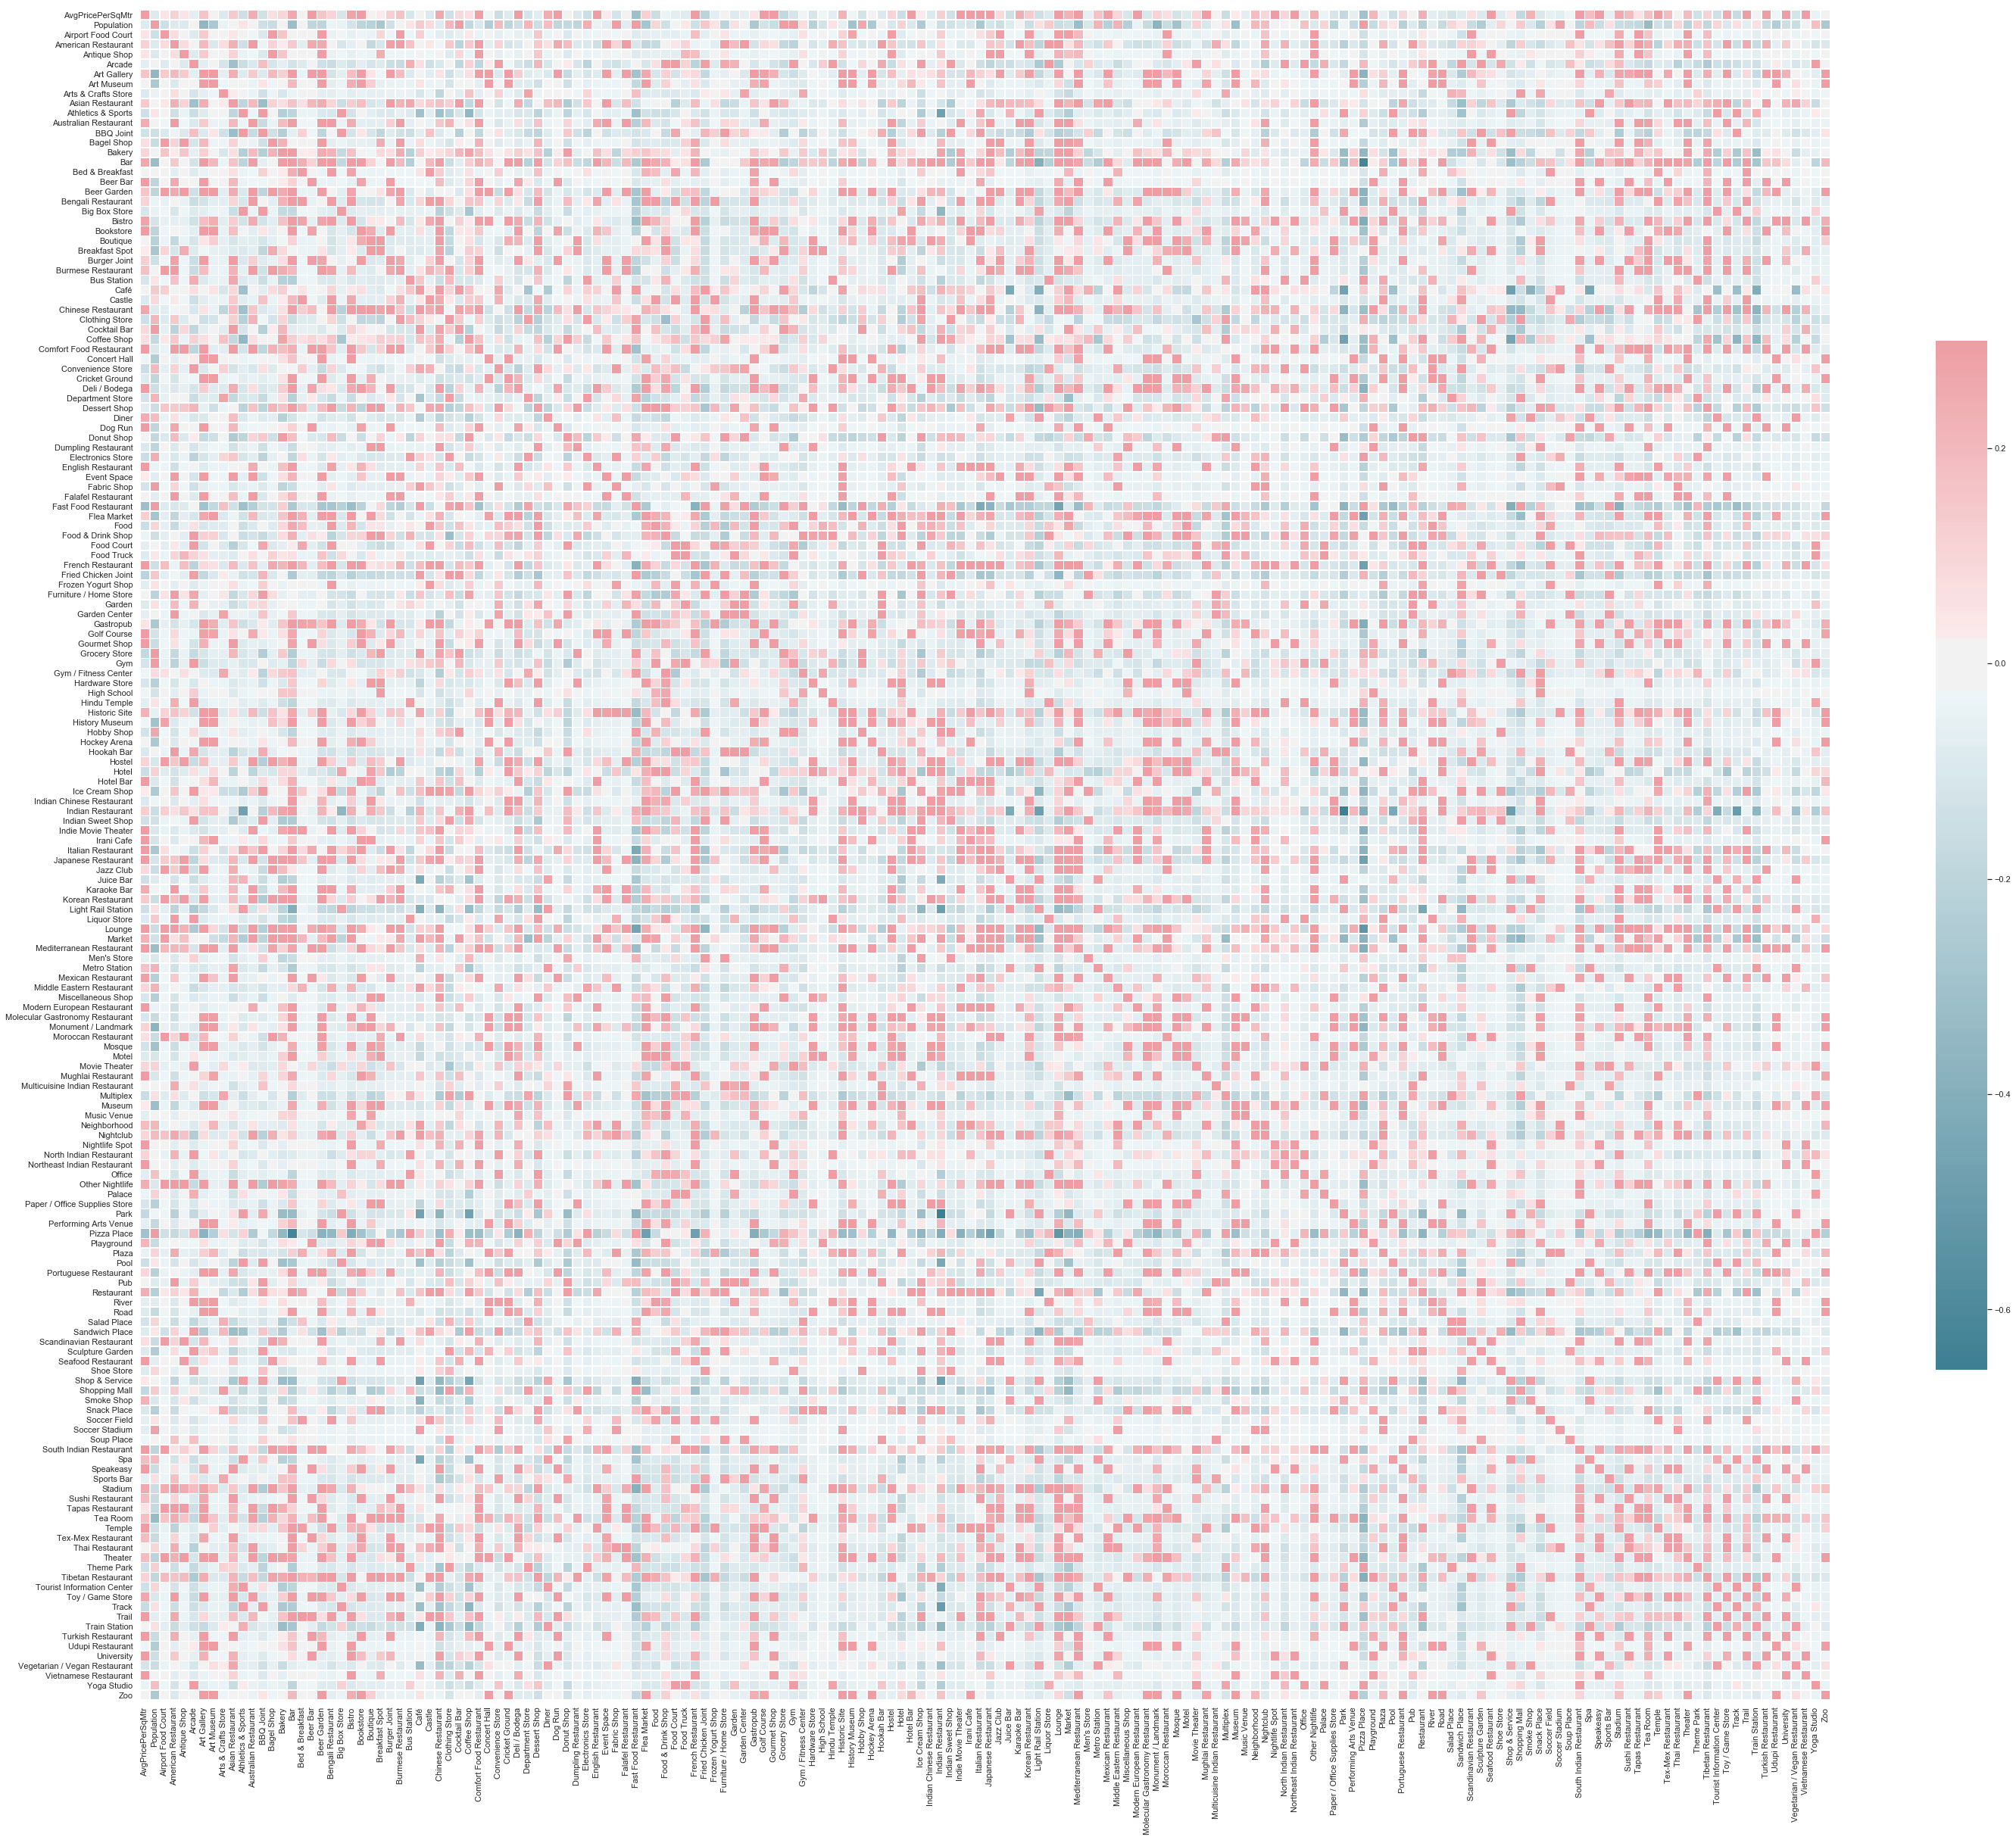

In [111]:
import seaborn as sns
sns.set(style="white")
corr = df1.corr()

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(50, 50))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

# 7. References

* [1] [Delhi Wikipedia](https://en.wikipedia.org/wiki/Delhi)
* [2] [Github Repository containing Wards Data](https://github.com/datameet/Municipal_Spatial_Data/blob/master/Delhi/Delhi_Wards.geojson?short_path=18d52b8)
* [3] [Foursquare API](https://developer.foursquare.com/)
* [4] [Population Data](https://indikosh.com/city/708693/delhi)
* [5] [Real Estate Prices](https://www.bankbazaar.com/home-loan/stamp-duty-and-property-registration-charges-delhi.html)